# Polish Twitter Partisan Networks

In [102]:
PATH = "/home/piotr/projects/twitter/"
PATH_DATA = '/media/piotr/INTENSO/polish_twitter_data/'
import sys
import os
sys.path.append(os.path.join(PATH, 'src'))
import re
import pandas as pd
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.clique import find_cliques
import numpy as np
import datetime
from datetime import datetime, timedelta
import gc
import json
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import twitter_models
from twitter_models.network import build_twitter_network_multi, build_twitter_network, multi_to_di
from twitter_tools.utils import check_errors, read_files, filter_date
cols_from = ["in_reply_to_user_id_str"]
cols_to = ["retweeted_status-user-id_str", "quoted_status-user-id_str"]
import logging
logger = logging.getLogger(__name__)
from functools import partial
from itertools import product
from operator import itemgetter
from twitter_tools.utils import filter_date

## Building networks partisan networks:
First, I build time-dynamic directional networks for both parties - government and opposition followers. The networks are represented as dictionaries of daily `networkx` objects, describing connections between the users in the sample. The edges are defined as followed:
- reply to a tweet (column `in_reply_to_user_id_str`) is treated as an directional edge from as an outgoing node from the user that replies
- retweet and quotation (columns `["retweeted_status-user-id_str", "quoted_status-user-id_str"]` in the Twitter API output) are treated as nodes going into the user

Each edge is associated with the tweet id string associated with that edge.

**Data filtering**
As per usual, I load the IDs that were judged to be removed in the preprocessing phase. I define a filter function to remove them from the data frames.

In [2]:
DROP_TWEETS = json.load(open(os.path.join(PATH, 'results/cleaning/drop_tweets.json'), 'r'))
DROP_USERS = json.load(open(os.path.join(PATH, 'results/cleaning/drop_users.json'), 'r'))
def filter_fun(df: pd.DataFrame, drop_ids: list, drop_users: list):
    df = df.loc[np.logical_not(df['id_str'].isin(drop_ids)),:]
    df = df.loc[np.logical_not(df['user-id_str'].isin(drop_users)),:]
    return df
ff = partial(filter_fun, drop_ids = DROP_TWEETS, drop_users = DROP_USERS)

## Build directional dynamic multi-graph for the data:

In [3]:
START = '2020_02_23'
END = '2020_07_15'

In [4]:
def join_networks(G1, G2, nodes_subset):
    g1 = G1.subgraph(nodes_subset) #keep just the joint nodes
    g2 = G2.subgraph(nodes_subset) #
    connected = nx.compose(g1, g2)
    connected.add_nodes_from(nodes_subset)
    return connected

In [116]:
os.remove(PATH_NETWORK)

In [26]:
PATH_NETWORK = os.path.join(PATH, 'results/network/partisan_network.p') #path to store network in
if os.path.isfile(PATH_NETWORK):
    partisan_network = pickle.load(open(PATH_NETWORK, 'rb'))
else:
    PATH_DATA = '/media/piotr/SAMSUNG/data/' #path to the data
    usecols = cols_from + cols_to + ['user-id_str', 'id_str', 'created_at'] #specify columns to use
    dtypes = {k:str for k in usecols} #specify dtypes for csv reader
    ids = dict()
    for src in ['gov', 'opp']:
        tmp = pickle.load(open(os.path.join(PATH, f'data/sample/{src}_sample.p'),'rb'))
        ids.update({k:src for k in tmp})
    #files to read:
    files = {source:sorted([f for f in os.listdir(os.path.join(PATH_DATA, source)) if 'csv' in f and filter_date(f, start = START, end = END)]) for source in ['gov','opp']}
    partisan_network = dict() #store networks
    for j in trange(len(files['gov'])):
        nets = dict()
        for i, source in enumerate(['gov', 'opp']):
            tmp_path = os.path.join(PATH_DATA, source, files[source][j])
            dat = pd.read_csv(tmp_path, index_col = 0, usecols = usecols, dtype = dtypes)
            dat.reset_index(inplace = True)
            dat = ff(dat)
            G = build_twitter_network_multi(dat, col_node = 'user-id_str', col_label = 'id_str', 
                                        cols_from = cols_from, cols_to = cols_to, filter_fun = ff)
            nets["G"+str(i+1)] = G #store in dict
        G = join_networks(**nets, nodes_subset = list(ids.keys())) #join
        nx.set_node_attributes(G, ids, 'source') #set source attr
        regex = '\d{4}\_\d{2}\_\d{2}'
        day = re.search(regex, files[source][j]).group(0)
        partisan_network[day] = G
        gc.collect()


    #add topic info
    topic_map = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topics.json'), 'r'))
    def map_topic(G, attribute, topic_dict):
        for n1, n2, edge in G.edges:
            if edge in topic_dict:
                G[n1][n2][edge][attribute] = topic_dict[edge]
            else:
                G[n1][n2][edge][attribute] = np.nan
        return G
    partisan_network = {k:map_topic(v, 'topic', topic_map) for k, v in partisan_network.items()}
    pickle.dump(partisan_network, open(PATH_NETWORK, 'wb'))

In [28]:
def filter_edges(G:nx.Graph, filter_fun):
    edges = []
    for n1, n2, w in G.edges:
        if filter_fun(G, n1, n2):
            edges.append((n1, n2, w))
    G1 = G.edge_subgraph(edges)
    return G1

def subset_edges(G:nx.Graph, names:list):
    edges = [(n1,n2,w) for n1,n2,w in tqdm(G.edges) if w in names]
    return G.edge_subgraph(edges)

def subset_edges_attr(G:nx.Graph, attr:str, names:list):
    edges = [(n1,n2,w) for n1,n2,w in G.edges if attr in G[n1][n2][w] and G[n1][n2][w][attr] in names]
    return G.edge_subgraph(edges)

In [29]:
def compute_homophily_network(G:nx.Graph):
    """
    Given a graph, compute its level of homophily, calculated as the ratio of the number of ingroup interactions to 
    outgroup interactions.
    """
    ff = lambda G, n1, n2, s1, s2: G.nodes[n1]['source'] == s1 and G.nodes[n2]['source'] == s2
    homophily = dict()
    homophily['gov_gov'] = len(filter_edges(G, filter_fun = partial(ff, s1 = 'gov', s2 = 'gov')).edges)
    homophily['opp_opp'] = len(filter_edges(G, filter_fun = partial(ff, s1 = 'opp', s2 = 'opp')).edges)
    homophily['gov_opp'] = len(filter_edges(G, filter_fun = partial(ff, s1 = 'gov', s2 = 'opp')).edges)
    homophily['opp_gov'] = len(filter_edges(G, filter_fun = partial(ff, s1 = 'opp', s2 = 'gov')).edges)
    homophily['overall'] = (homophily['gov_gov'] + homophily['opp_opp'])/(homophily['gov_opp'] + homophily['opp_gov'])
    return homophily

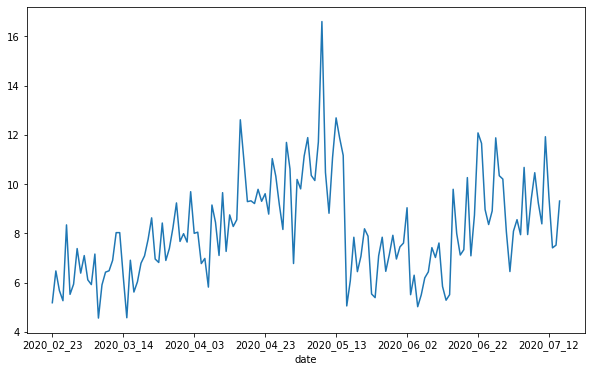

In [30]:
hmp = {day:compute_homophily_network(G) for day, G in partisan_network.items()}
hmp = pd.DataFrame(hmp).reset_index().melt('index', var_name = 'date', value_name = 'homiphily')
hmp = hmp.pivot(index = 'date', columns = 'index', values = 'homiphily')
hmp.reset_index().plot('date', 'overall', figsize = (10, 6), legend = False)
plt.show()

In [98]:
hmpt = defaultdict(dict)
for topic in tqdm(np.unique(sorted(np.unique(list(topic_map.values()))))):
    for date, network in partisan_network.items():
        M = subset_edges_attr(network, 'topic', [topic])
        try:
            hmpt[topic][date] = compute_homophily_network(M)
        except ZeroDivisionError:
            hmpt[topic][date] = defaultdict(lambda: np.nan)
hmpt = dict(hmpt)
hmpt = {k:{k1:v1['overall'] for k1, v1 in v.items()} for k, v in hmpt.items()}
hmpt = pd.DataFrame.from_dict(hmpt).reset_index().melt('index', var_name = 'topic', value_name = 'homophily')
hmpt.columns = ['date', 'topic', 'homophily']

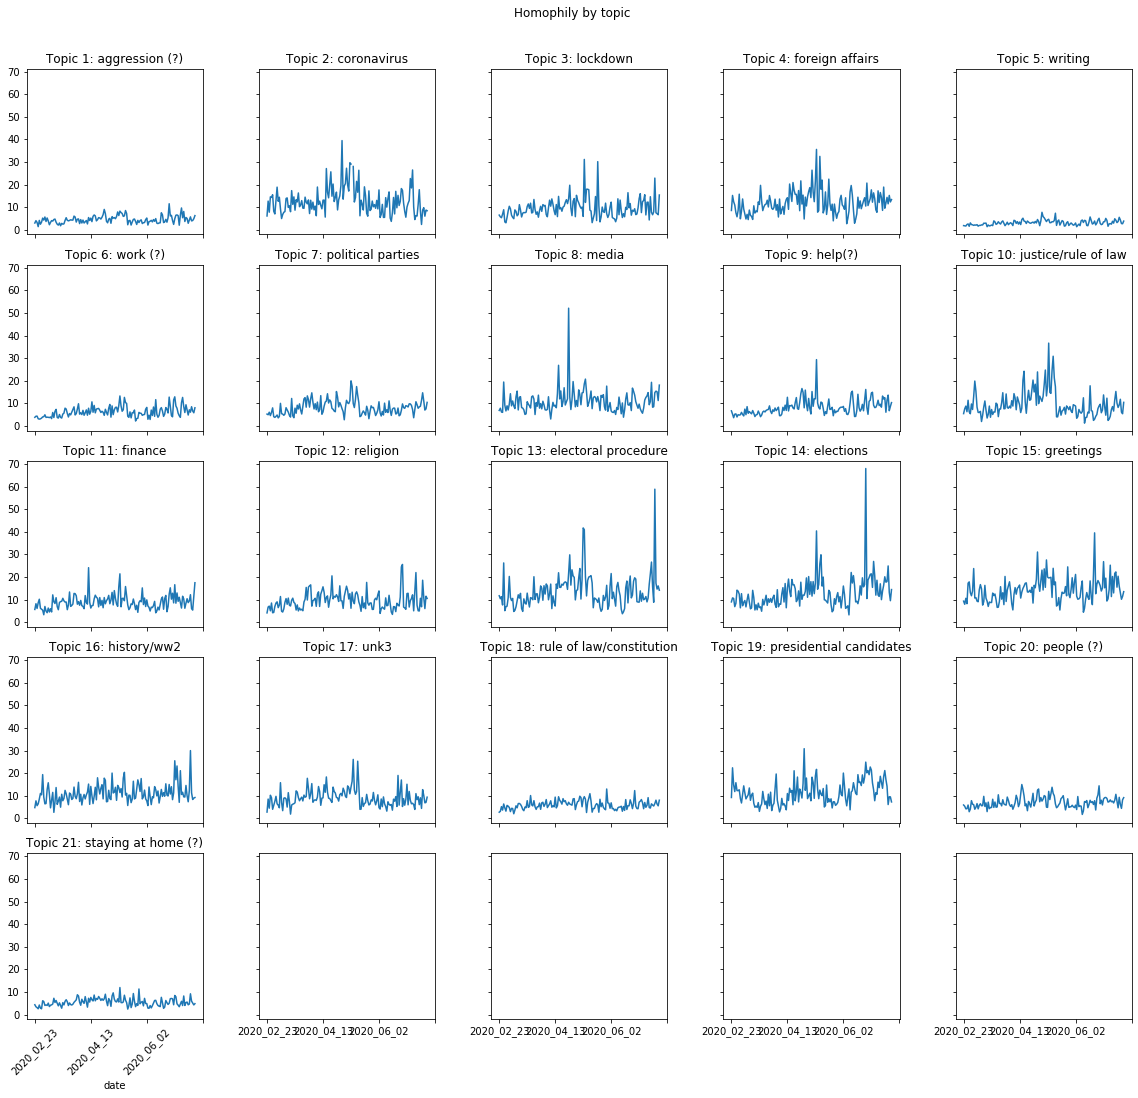

In [101]:
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topic_dict.json'),'r'))
fig, ax = plt.subplots(5, 5, figsize = (16, 16), sharex = True, sharey = True)
ax = ax.ravel()
fig.suptitle('Homophily by topic')
hmpt['homiphily'] = hmpt.groupby('topic').apply(lambda x: x['homophily'].interpolate(method = 'linear', limit_direction = 'both')).reset_index(drop = True)
for topic, df in hmpt.groupby('topic'):
    df.plot('date','homophily', rot = 45, ax = ax[topic-1], legend = False)
    ax[topic-1].set_title(f'Topic {topic}: {topic_dict[str(topic)]}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Aggregate the networks to identify relevant cliques:

In [103]:
def aggregate_multigraph(M):
    G = nx.Graph()
    for u,v in M.to_undirected().edges():
        if G.has_edge(u,v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

def aggregate_dynagraph(M:dict):
    G = nx.Graph()
    for k, v in M.items():
        G.add_edges_from(v.edges())
    return G

partisan_network = {k:aggregate_multigraph(v) for k, v in partisan_network.items()}
partisan_network = aggregate_dynagraph(partisan_network)

In [ ]:
for c in tqdm(k_clique_communities(partisan_network, 5)):
    pass